# MODIS Pipeline Walkthrough

In this demo, we will do a full walkthrough of a minimal MODIS pipeline to get some data for training

In [1]:
import autoroot
from rs_tools._src.utils.io import get_list_filenames
import rioxarray
import xarray as xr
import numpy as np
import earthaccess
from pathlib import Path
from rs_tools._src.data.modis.bands import MODIS_VARIABLES
from rs_tools._src.data.modis import MODISFileName, MODIS_ID_TO_NAME, MODIS_NAME_TO_ID, get_modis_paired_files

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dataclasses import dataclass
from tqdm.auto import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:522: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


In [2]:
save_dir_raw = "/home/juanjohn/data/rs/modis/raw/modis"
save_dir_analysis = "/home/juanjohn/data/rs/modis/analysis/"
save_dir_mlready = "/home/juanjohn/data/rs/modis/mlready/"

## 1 - Download Data

For this case, we are going to download MODIS data.

* AQUA - "MYDO21KM"
* TERRA - "MODO21KM"
* Geolocation - "MYDO3"

**Resources**:
* NASA LAADS - [Webpage](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/science-domain/modis-L0L1/)

In [4]:
earthaccess.login()

#### Demo: Terra

In [5]:
results = earthaccess.search_data(
    short_name=MODIS_NAME_TO_ID["terra"], # 'MYD03' # "MYD021KM"
    cloud_hosted=True,
    bounding_box=(-130, -15, -90, 5),
    temporal=("2018-10-01 08:00", "2018-10-01 20:00"),
    count=-1
)
results[0]

Granules found: 5


Collection: {'ShortName': 'MOD021KM', 'Version': '6.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -93.519163, 'Latitude': -16.615312}, {'Longitude': -71.610842, 'Latitude': -19.897712}, {'Longitude': -68.271652, 'Latitude': -1.855952}, {'Longitude': -89.116255, 'Latitude': 1.202545}, {'Longitude': -93.519163, 'Latitude': -16.615312}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2018-10-01T15:45:00.000Z', 'EndingDateTime': '2018-10-01T15:50:00.000Z'}}
Size(MB): 142.835767745972
Data: ['https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2018/274/MOD021KM.A2018274.1545.061.2018275090337.hdf']

### Download Loop

In [6]:
# pbar = tqdm(list(modis_satellite_names.values()))

# for isatellite in pbar:

#     # search for data in database
#     results = earthaccess.search_data(
#         short_name=isatellite,
#         cloud_hosted=True,
#         bounding_box=(-130, -15, -90, 5),
#         temporal=("2018-10-01 08:00", "2018-10-01 20:00"),
#         count=-1
#     )

#     # download if something found
#     if len(results) != 0:
#         earthaccess.download(results, save_dir_raw)

## 2 - Loading Data

1. Get All Files
2. Create MODISFileName Identifiers
3. Filter Based on criteria

In [7]:
modis_files = get_list_filenames(save_dir_raw, ".hdf")
modis_files[0], len(modis_files)

('/home/juanjohn/data/rs/modis/raw/modis/MOD021KM.A2018274.1545.061.2018275090337.hdf',
 22)

In [8]:
from typing import List


# get all modis files
modis_filenames: List[MODISFileName] = list(map(lambda x: MODISFileName.from_filename(x), modis_files))

# get paired files for satellites
paired_files_terra = get_modis_paired_files(modis_filenames, "terra")

Now, we will filter for the unique datetimes

### Open File

In [9]:
import satpy
from satpy import Scene
from rs_tools import get_modis_channel_numbers
import rioxarray
import xarray as xr

In [10]:
demo = next(iter(paired_files_terra))

In [11]:
list(paired_files_terra.keys())

['201810011545',
 '201810011720',
 '201810011725',
 '201810011900',
 '201810011905',
 '201810021625',
 '201810021630',
 '201810021805',
 '201810021810',
 '201810021940',
 '201810021945']

## Bands

In [12]:
scn = Scene(
    reader="modis_l1b", 
    filenames=[
        str(paired_files_terra[demo]["data"].full_path),
    ], 
    reader_kwargs={"calibration": "radiance"}
)
resolution = 1_000 # km scale
scn.load(get_modis_channel_numbers(), resolution = resolution)

# change to xarray data
ds_modis = scn.to_xarray_dataset()


In [13]:
# ds_modis

In [14]:
# create new channel dimension
ds_modis = xr.concat(list(map(lambda x: ds_modis[x], get_modis_channel_numbers())), dim="channel")
# rename channel dimensions
ds_modis = ds_modis.assign_coords(channel=list(map(lambda x: x, get_modis_channel_numbers())))

In [15]:
ds_modis

<xarray.DataArray '1' (channel: 38, y: 2030, x: 1354)> Size: 836MB
dask.array<concatenate, shape=(38, 2030, 1354), dtype=float64, chunksize=(1, 1540, 1354), chunktype=numpy.ndarray>
Coordinates:
    crs        object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude   (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude  (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
  * channel    (channel) <U4 608B '1' '2' '3' '4' ... '35' '36' '13hi' '14hi'
Dimensions without coordinates: y, x
Attributes: (12/18)
    name:                 1
    resolution:           1000
    calibration:          reflectance
    coordinates:          ('longitude', 'latitude')
    wavelength:           0.645 µm (0.62-0.67 µm)
    file_type:            hdf_eos_data_1000m
    ...                   ...
    start_time:           2018-10-01 15:45:00
    end_time:             2018-10-01 15:50:00
    reader:               modis_l1b
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    _satpy_id:            DataID(name='1', wavelength=WavelengthRange(min=0.6...
    ancillary_variables:  []

#### Load Mask

In [16]:
scn = Scene(
    reader="modis_l2", 
    filenames=[
        str(paired_files_terra[demo]["cloud"].full_path),
    ], 
    reader_kwargs={"calibration": "radiance"}
)
resolution = 1_000 # km scale
scn.load(["cloud_mask"], resolution = resolution)

### Saving Data Structure

In [17]:
from datetime import datetime

In [18]:
ds_modis = ds_modis.assign_coords({"cloud_mask": (("y","x"),scn["cloud_mask"].values)})
ds_modis = ds_modis.expand_dims(time=[datetime.strptime(demo, "%Y%m%d%H%M"),])
ds_modis = ds_modis.drop_vars("crs")


useful_keys = ["calibration", "wavelength", "standard_name"]
ds_modis.attrs = {k: v for k, v in ds_modis.attrs.items() if k in useful_keys}

ds_modis.name = "reflectance"
ds_modis

<xarray.DataArray 'calibration' (time: 1, channel: 38, y: 2030, x: 1354)> Size: 836MB
dask.array<broadcast_to, shape=(1, 38, 2030, 1354), dtype=float64, chunksize=(1, 1, 1540, 1354), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 8B 2018-10-01T15:45:00
    latitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude   (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
  * channel     (channel) <U4 608B '1' '2' '3' '4' ... '35' '36' '13hi' '14hi'
    cloud_mask  (y, x) uint8 3MB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 1 2 1 1 0 0 0 0 0
Dimensions without coordinates: y, x
Attributes:
    calibration:    reflectance
    wavelength:     0.645 µm (0.62-0.67 µm)
    standard_name:  toa_bidirectional_reflectance

## Stage 3

* Normalization
* Patching

#### Running Mean

In [19]:
def mean_preprocess(ds):
    # calculate the mean
    ds = ds.reflectance.mean(["x", "y"])
    return ds

In [20]:
ds_mean = xr.open_mfdataset(str(Path(save_dir_analysis).joinpath("*.nc")), preprocess=mean_preprocess, combine="by_coords",  engine="netcdf4")

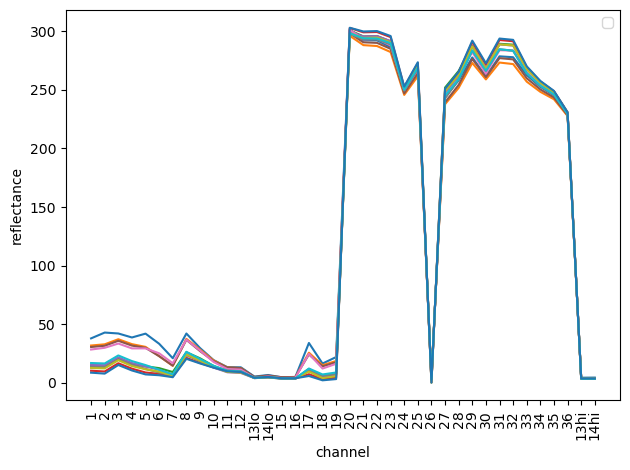

In [21]:
fig, ax = plt.subplots()
ds_mean.reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [22]:
ds_mean = ds_mean.mean(["time"])

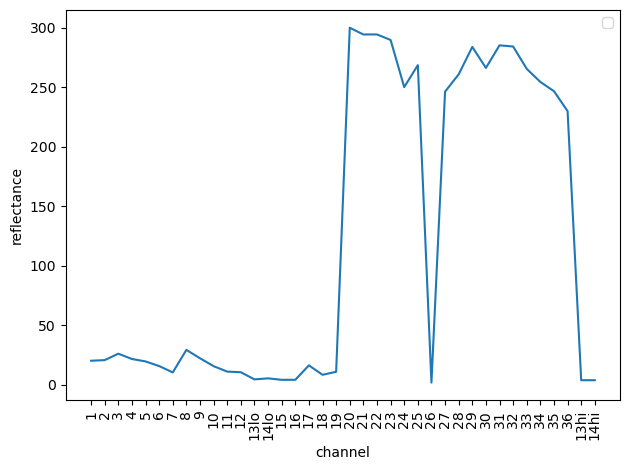

In [23]:
fig, ax = plt.subplots()
ds_mean.reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [24]:
def std_preprocess(ds):
    # calculate the mean
    ds = ((ds.reflectance - ds_mean)**2).std(["x","y"])
    return ds

In [25]:
ds_std = xr.open_mfdataset(str(Path(save_dir_analysis).joinpath("*.nc")), preprocess=std_preprocess, combine="by_coords",  engine="netcdf4")

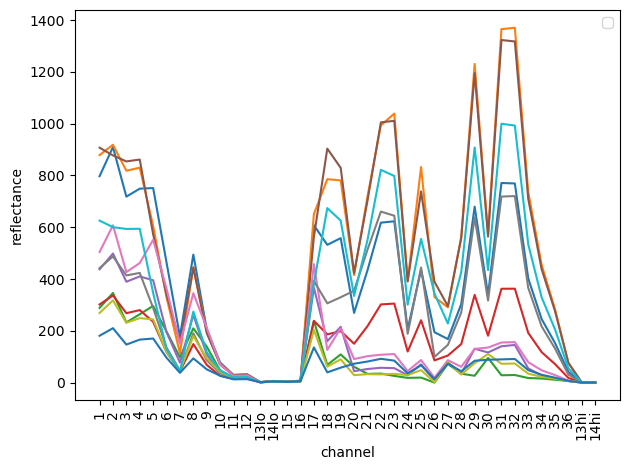

In [26]:
fig, ax = plt.subplots()
ds_std.reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

In [27]:
ds_std = ds_std.mean(["time"])

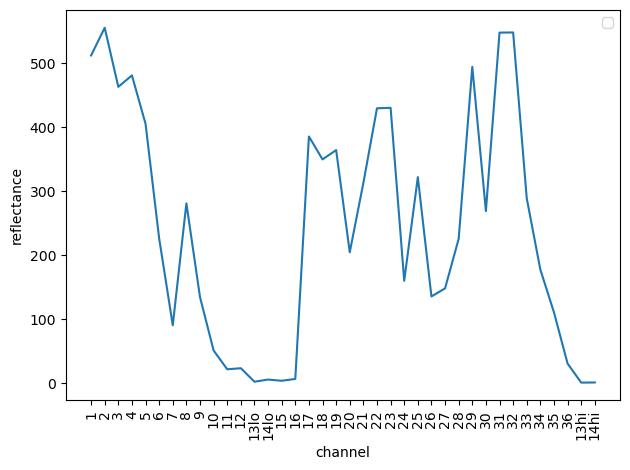

In [28]:
fig, ax = plt.subplots()
ds_std.reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

### Normalization

In [23]:
ds["mean"] = ds.mean(["x", "y", "time"]).reflectance
ds["std"] = ds.mean(["x", "y", "time"]).reflectance

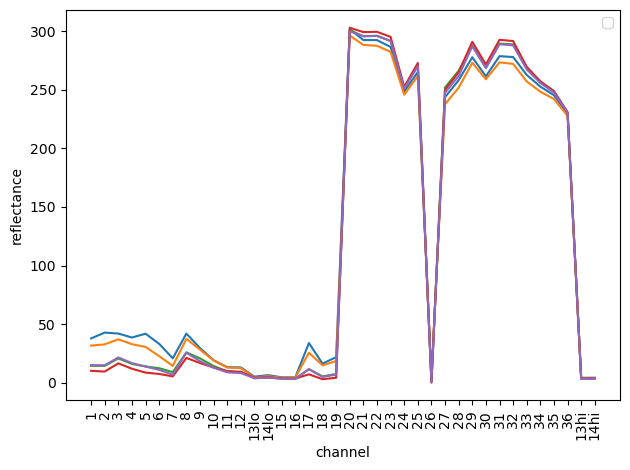

In [24]:
fig, ax = plt.subplots()
ds.mean(["x", "y"]).reflectance.plot.line(x="channel", ax=ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend([])
plt.show()

### Patching

In [59]:
from xrpatcher._src.base import XRDAPatcher

In [60]:
patches = dict(x=256, y=256)
strides = dict(x=64, y=64)
patcher = XRDAPatcher(da=ds.reflectance, patches=patches, strides=strides)

In [61]:
len(patcher)

504

In [62]:
ipatch = patcher[0]
ipatch

<xarray.DataArray 'reflectance' (time: 5, channel: 38, y: 256, x: 256)> Size: 100MB
dask.array<getitem, shape=(5, 38, 256, 256), dtype=float64, chunksize=(1, 38, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 40B 2018-10-01T15:45:00 ... 2018-10-01T...
    latitude    (time, y, x) float32 1MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    longitude   (time, y, x) float32 1MB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
  * channel     (channel) <U4 608B '1' '2' '3' '4' ... '35' '36' '13hi' '14hi'
    cloud_mask  (time, y, x) uint8 328kB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    calibration:    reflectance
    wavelength:     ['0.62', '0.645', '0.67', 'µm']
    standard_name:  toa_bidirectional_reflectance

In [63]:

for i, ipatch in enumerate(patcher):
    # save as numpy files
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_reflectance_patch_{i}.npz"), ipatch.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_latitude_patch_{i}.npz"), ipatch.latitude.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_longitude_patch_{i}.npz"), ipatch.longitude.values)
    np.savez(Path(save_dir_mlready).joinpath(f"{demo}_cloudmask_patch_{i}.npz"), ipatch.cloud_mask.values)
    break

In [28]:
mldata_dir = Path("/home/juanjohn/data/rs/modis/test/mlready")

In [29]:
!ls $mldata_dir

201810011545_cloudmask_patch_0.npz  201810011545_longitude_patch_0.npz
201810011545_latitude_patch_0.npz   201810011545_reflectance_patch_0.npz


In [ ]:
img = np.load(path, mmap_mode="r+")

In [333]:
import glob
def files(root: Path):
    files = [str(f) for f in root.glob("**/*.npz")]

    return [
        dict(image=f.encode("ascii")) for f in files
    ]

In [339]:
out = files(Path(mldata_dir))
len(out)

10

In [340]:
out[0]["image"].decode()

'/home/juanjohn/data/rs/modis/test/mlready/201810011545_patch0.npz'

In [343]:
# # create composition function
# fn: Callable[[str], np.ndarray] = compose_left(
#     # convert ascii to string
#     lambda x: x.tobytes().decode("ascii"), 
#     # helio-processing chain
#     fn1, fn2, fn3, fn5, 
#     # convert to numpy array
#     lambda x: x.data,
#     # reshape data
#     lambda x: rearrange(x, "H W -> H W 1")
# )



In [ ]:
import mlx.data as dx
batch_size = 16

dset = (
    # make a buffer (finite length container of samples) from python list
    dx.buffer_from_vector(files(mldata_dir))
    # shuffle and transform to stream
    .shuffle()
    .to_stream()
    # .load_numpy("image")
    .key_transform("image", lambda x: np.load(x)["lats"], "lats")
    # implement preprocessing pipeline
    # .key_transform("image", fn)
    # .image_random_crop("image", 256, 256)
    # .key_transform("image", lambda x: x.astype("float32"))
    .batch(batch_size)
    .prefetch(prefetch_size=8, num_threads=4)
)

In [ ]:
from tqdm.auto import tqdm, trange
epoch_bar = trange(10_000)
for i in epoch_bar:
    for sample in dset:
        print(sample['image'].shape)
        # epoch_bar.set_description(f"Epoch: {i} | Sample Size: {sample['image'].shape}")

sample["image"].shape

## Dataset / DataLoader

In [ ]:

class S2Geo(NonGeoDataset):
    """S2-100K dataset.

    This dataset contains 100,000 256x256 patches of 12 band Sentinel imagery sampled randomly
    from Sentinel 2 scenes on the Microsoft Planetary Computer that have <20% cloud cover,
    intersect land, and were captured between 2021-01-01 and 2023-05-17 (there are 2,359,972
    such scenes).
    """

    validation_filenames = [
        "index.csv",
        "images/",
        "images/patch_0.tif",
        "images/patch_99999.tif",
    ]

    def __init__(
        self,
        root: str,
        transform: Optional[Callable[[Dict[str, Tensor]], Dict[str, Tensor]]] = None,
        mode: Optional[str] = "both",
    ) -> None:
        """Initialize a new S2-100K dataset instance.
        Args:
            root: root directory of S2-100K pre-sampled dataset
            transform: torch transform to apply to a sample
            mode: which data to return (options are "both" or "points"), useful for embedding locations without loading images 
        """
        assert mode in ["both", "points"]
        self.root = root
        self.transform = transform
        self.mode = mode

        

    def __getitem__(self, index: int) -> Dict[str, Tensor]:
        """Return an index within the dataset.
        Args:
            index: index to return
        Returns:
            dictionary with "image" and "point" keys where point is in (lon, lat) format
        """
        point = torch.tensor(self.points[index])
        sample = {"point": point}

        if self.mode == "both":
            with rasterio.open(self.filenames[index]) as f:
                data = f.read().astype(np.float32)
            #img = torch.tensor(data)
            sample["image"] = data
            
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample

    def __len__(self) -> int:
        """Return the number of datapoints in the dataset.
        Returns:
            length of dataset
        """
        return len(self.filenames)

In [44]:
from torchgeo.datasets import RasterDataset, stack_samples, BoundingBox
from torchgeo.samplers import GridGeoSampler, RandomGeoSampler
from torch.utils.data import DataLoader

In [18]:
import rasterio as rio
with rio.open("/home/juanjohn/projects/rs_tools/notebooks/dev/eman/test.tif", 'r') as f:
    img = f.read()
    print(img.shape)
    # img = img.transpose(1, 2, 0)

(2, 2030, 1354)


In [13]:
img.shape

(2, 2030, 1354)

In [30]:
# tds = RasterDataset(paths=list_of_files[0])
tds = RasterDataset(paths="/home/juanjohn/projects/rs_tools/notebooks/dev/eman/test.tif")
# roi = BoundingBox(40,50,50,60)
# sampler = GridGeoSampler(tds, size=(256,256), stride=(256,256), )
sampler = RandomGeoSampler(tds, size=(256,256), length=10)
tdl = DataLoader(tds, sampler=sampler, collate_fn=stack_samples)

In [31]:
isample["image"].shape

torch.Size([1, 38, 256, 256])

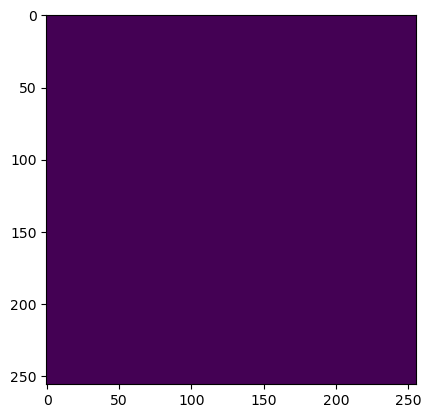

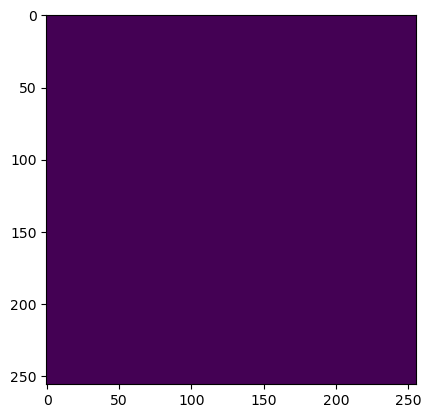

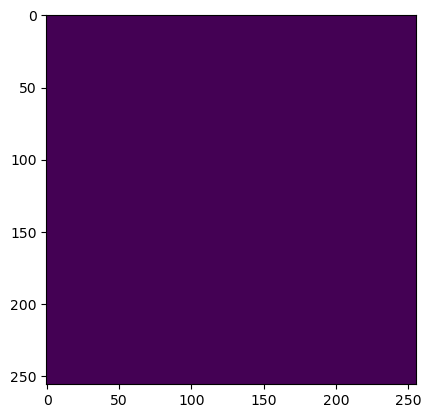

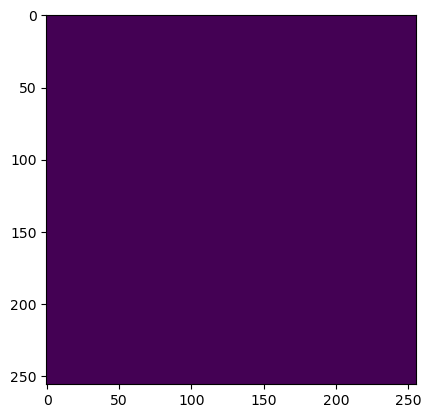

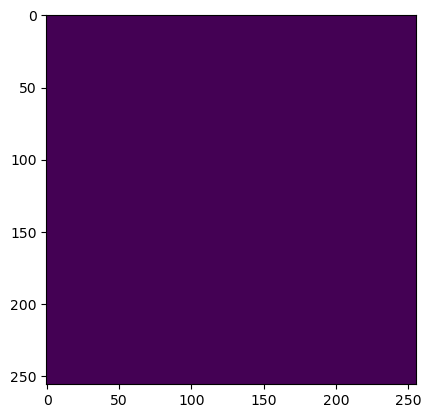

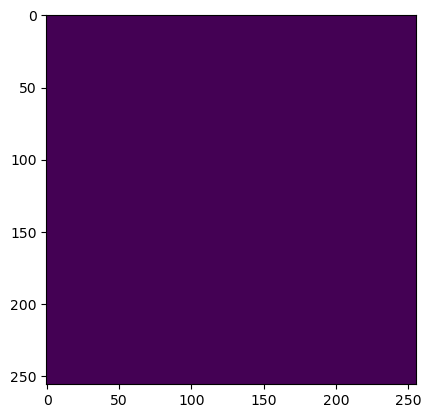

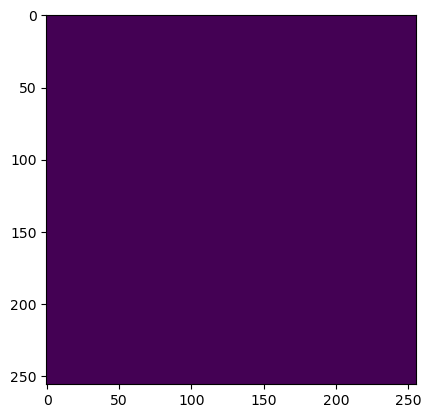

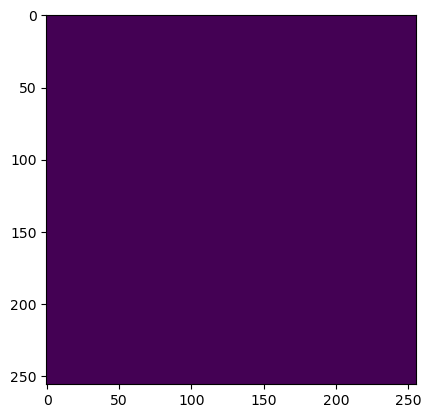

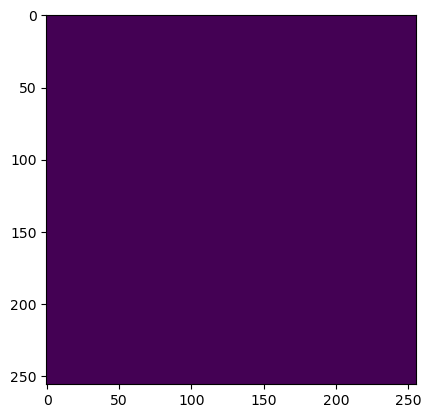

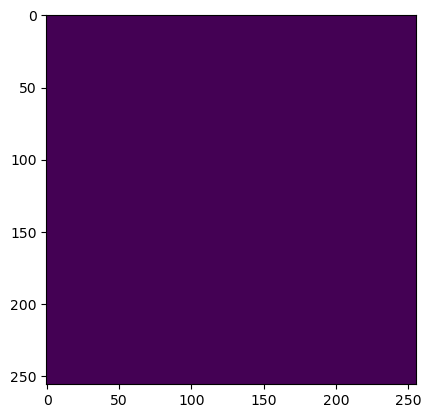

In [33]:
for i, isample in enumerate(tdl):
    fig, ax = plt.subplots()
    
    ax.imshow(isample["image"].numpy().squeeze().transpose(1,2,0)[...,2])
    plt.show()

    if i > 10:
        break


In [150]:
isample["image"].shape

torch.Size([1, 38, 256, 256])

In [143]:
isample["image"].numpy().max() > 0.0

False

In [144]:
isample["image"].max()

tensor(nan)

In [145]:
isample["image"].numpy().squeeze().transpose(1,2,0)[...,1:4]

array([[[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       ...,

       [[ 40.224533, 230.73936 , 264.02652 ],
        [ 38.897587, 231.26094 , 263.35553 ],
        [ 39.64807 , 2

In [ ]:
NonGeoDataset

In [106]:
# scn.save_datasets(writer="geotiff", filename="test.tif")

In [50]:
def coords_to_transform(coords) -> rasterio.Affine:
    """
    Compute the bounds and the geotransform from the coordinates of a xr.DataArray object.

    This function is an inverse of the coordinates computation that is in `xr.open_rasterio`

    Args:
        coords: if `data` is an xr.DataArray object data.coords has its coordinates

    Returns:
        Bounds and geotransform of the coordinates.
    """

    resx = float(abs(coords["x"][1] - coords["x"][0]))
    resy = float(abs(coords["y"][1] - coords["y"][0]))
    resx2 = resx / 2.
    resy2 = resy / 2.

    x_min = float(coords["x"][0] - resx2)
    x_max = float(coords["x"][-1] - resx2 + resx)  # why not + resx2
    y_max = float(coords["y"][0] + resy2)
    y_min = float(coords["y"][-1] + resy2 - resy)  # why not - resy2

    # We add in the y coordinate because images are referenced from top coordinate,
    # see xr.open_rasterio or getcoords_from_transform_shape
    bounds = (x_min, y_min, x_max, y_max)

    # Compute affine transform for a given bounding box and resolution.
    transform = rasterio.transform.from_origin(bounds[0], bounds[3], resx, resy)

    return transform

In [133]:
import georeader

In [138]:
ds_modis = scn.to_xarray_dataset()
# reference CRS of Swath data
crs_WGS84 = ccrs.PlateCarree(central_longitude=0) 
ds_modis.rio.write_crs(4326, inplace=True)
ds_modis.rio.write_coordinate_system(inplace=True)
# transform = coords_to_transform(ds_modis)
# ds_modis.rio.write_transform(transform, inplace=True)
ds_modis

<xarray.Dataset> Size: 616MB
Dimensions:      (y: 2030, x: 1354)
Coordinates:
    crs          object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude     (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables: (12/38)
    21           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    6            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    20           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    30           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    9            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    25           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...           ...
    4            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    29           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    22           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    18           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    26           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    33           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    resolution:           1000
    sensor:               modis
    start_time:           2018-10-01 15:45:00
    reader:               modis_l1b
    file_type:            hdf_eos_data_1000m
    platform_name:        EOS-Terra
    end_time:             2018-10-01 15:50:00
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'array...
    ancillary_variables:  []
    coordinates:          ('longitude', 'latitude')
    rows_per_scan:        10
    modifiers:            ()

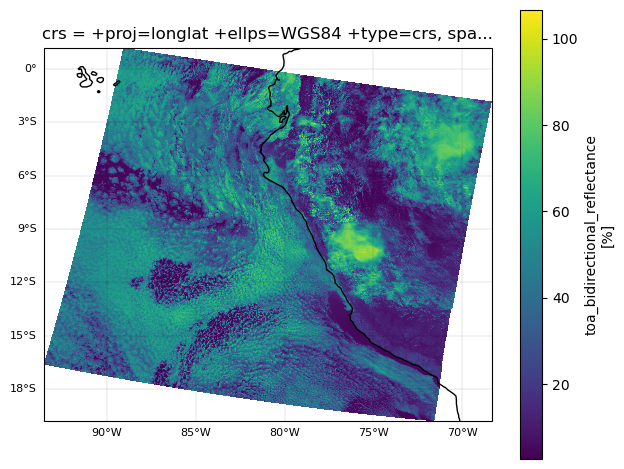

In [117]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-20, -10, 30, 60])
# out["1"].plot(ax=ax, transform=ccrs.PlateCarree())
# ax.pcolormesh(out["1"].longitude, out["1"].latitude, out["1"].values)
ds_modis["1"].plot.pcolormesh(x="longitude", y="latitude", transform=ccrs.PlateCarree())


# ax.set(xlim=[-20, 70,],
#       ylim=[ -10, 70])

# # Add map features with Cartopy 
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                             edgecolor='face', 
#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

In [120]:
ds_modis.rio.to_raster("test.tif")

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [121]:
d = xr.open_dataset("test.tif", engine="rasterio")
d

<xarray.Dataset> Size: 836MB
Dimensions:      (band: 38, x: 1354, y: 2030)
Coordinates:
  * band         (band) int64 304B 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38
  * x            (x) float64 11kB 0.5 1.5 2.5 ... 1.352e+03 1.352e+03 1.354e+03
  * y            (y) float64 16kB 0.5 1.5 2.5 ... 2.028e+03 2.028e+03 2.03e+03
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float64 836MB ...

In [49]:
# d.rio.write_crs(4326,inplace=True,)
d

<xarray.Dataset> Size: 836MB
Dimensions:      (band: 38, x: 1354, y: 2030)
Coordinates:
  * band         (band) int64 304B 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38
  * x            (x) float64 11kB 0.5 1.5 2.5 ... 1.352e+03 1.352e+03 1.354e+03
  * y            (y) float64 16kB 0.5 1.5 2.5 ... 2.028e+03 2.028e+03 2.03e+03
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float64 836MB ...

In [122]:
import pyproj
def convert_x_y_to_lat_lon(crs: str, x: list[float], y: list[float]) -> tuple[float, float]:
    transformer = pyproj.Transformer.from_crs(crs, "epsg:4326", always_xy=True)
    lons, lats = transformer.transform(x, y)
    return lons, lats

In [123]:
d.spatial_ref

<xarray.DataArray 'spatial_ref' ()> Size: 8B
[1 values with dtype=int64]
Coordinates:
    spatial_ref  int64 8B ...
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 0.0 1.0 0.0 0.0 0.0 1.0

In [124]:
import numpy as np

X, Y = np.meshgrid(d.x.values, d.y.values, indexing="ij")

In [132]:
import rasterio
rasterio.transform.xy(transform, d.x.values.ravel(), d.y.values.ravel())

TransformError: Input coordinates must be broadcastable to a 1d array

In [125]:
lons, lats = convert_x_y_to_lat_lon(d.rio.crs, X, Y)

In [126]:
lons.min(), lons.max()

(0.5, 1353.5)

In [43]:
# d = d.assign_coords({"longitude":(("x", "y"), lons)})
# d = d.assign_coords({"latitude":(("x", "y"), lats)})
# d.rio.set_spatial_dims(
#     x_dim="longitude",
#     y_dim="latitude",
#     inplace=True)
d.rio.write_coordinate_system(inplace=True)

<xarray.Dataset> Size: 880MB
Dimensions:      (band: 38, x: 1354, y: 2030)
Coordinates:
  * band         (band) int64 304B 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38
  * x            (x) float64 11kB 0.5 1.5 2.5 ... 1.352e+03 1.352e+03 1.354e+03
  * y            (y) float64 16kB 0.5 1.5 2.5 ... 2.028e+03 2.028e+03 2.03e+03
    spatial_ref  int64 8B 0
    longitude    (x, y) float64 22MB 0.5 0.5 0.5 0.5 ... -86.5 -86.5 -86.5 -86.5
    latitude     (x, y) float64 22MB 0.5 1.5 2.5 ... 2.029e+03 2.03e+03
Data variables:
    band_data    (band, y, x) float64 836MB ...

In [39]:
d.rio.crs.to_proj4()

'+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +to_meter=111319.490793274 +no_defs=True'

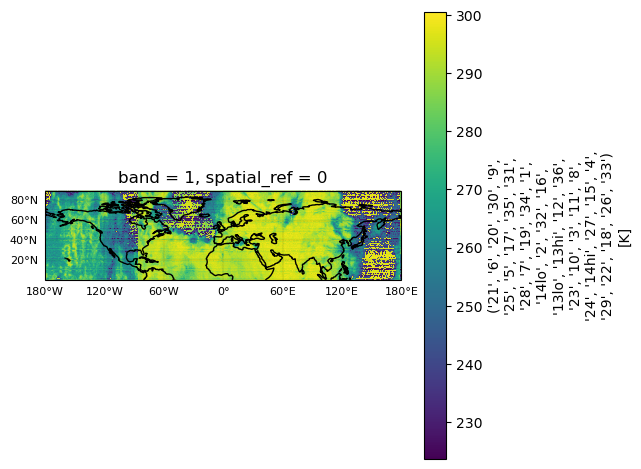

In [41]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-20, -10, 30, 60])
# out["1"].plot(ax=ax, transform=ccrs.PlateCarree())
# ax.pcolormesh(out["1"].longitude, out["1"].latitude, out["1"].values)
d.band_data.sel(band=1).plot.pcolormesh(transform=ccrs.PlateCarree())


# # Add map features with Cartopy 
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                             edgecolor='face', 
#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

In [119]:
ds_modis["1"].plot.pcolormesh()

KeyError: "No variable named '1'. Variables on the dataset include ['crs', 'cloud_mask', 'latitude', 'longitude', 'spatial_ref']"

In [112]:
scn = Scene(
    reader="modis_l2", 
    filenames=[
        str(paired["201810010755"]["cloud"].full_path),
    ], 
)
resolution = 1_000 # km scale
scn.load(["cloud_mask"], resolution = resolution)

In [113]:
out = scn.to_xarray_dataset()

In [114]:
ds_modis["cloud_mask"] = out["cloud_mask"]

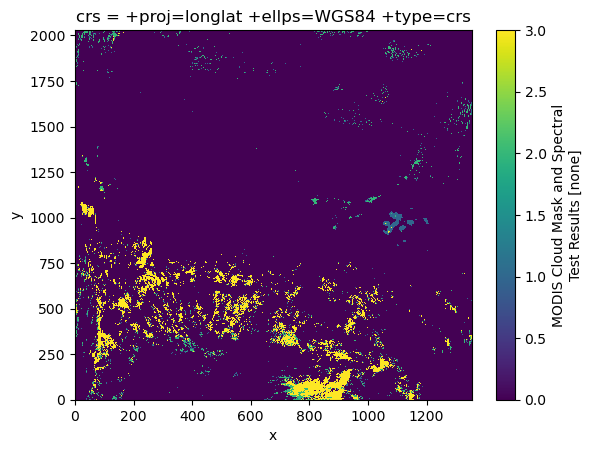

In [116]:
ds_modis["cloud_mask"].plot.pcolormesh()

In [71]:
out

<xarray.Dataset> Size: 616MB
Dimensions:      (y: 2030, x: 1354)
Coordinates:
    crs          object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude     (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables: (12/38)
    33           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    4            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    31           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    29           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    9            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    5            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...           ...
    28           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    30           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    21           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    35           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    34           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    7            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    rows_per_scan:        10
    coordinates:          ('longitude', 'latitude')
    modifiers:            ()
    file_type:            hdf_eos_data_1000m
    end_time:             2018-10-01 15:50:00
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'array...
    resolution:           1000
    start_time:           2018-10-01 15:45:00
    platform_name:        EOS-Terra
    ancillary_variables:  []
    reader:               modis_l1b
    sensor:               modis

In [4]:
f_geo = "/home/juanjohn/data/rs/modis/raw/geo/MYD03.A2018274.0900.061.2018274165900.hdf"
f_lb1 = "/home/juanjohn/data/rs/modis/raw/l1b/MOD021KM.A2018274.0900.061.2018274200126.hdf"

In [5]:
def get_file_time_info(radiance_filename, split_char='MYD021KM.A'):
    print(radiance_filename)
    time_info = radiance_filename.split(split_char)[1]
    year, abs_day = time_info[:4], time_info[4:7]
    hour, minute = time_info[8:10], time_info[10:12]

    return year, abs_day, hour, minute

In [6]:
get_file_time_info(str(Path(f_lb1).name), "MOD021KM")

MOD021KM.A2018274.0900.061.2018274200126.hdf


('.A20', '182', '4.', '09')

In [45]:
from rs_tools._src.utils import crs_ops


In [66]:
# - Define the CRS of the original data
crs_proj = ccrs.PlateCarree(central_longitude=0)
# Extract PROJ4 string from cartopy CRS
proj4_string = crs_proj.proj4_init 
# define bounding box
bbox = (-20, -10, 30, 60)

In [59]:
# # - Define the CRS of the original data
# crs_ref = ccrs.PlateCarree(central_longitude=0)


# # - Project bbox into the new CRS
# bbox_proj = crs_ops.get_projected_bbox(bbox, crs_ref = crs_ref, crs_proj = crs_proj)
# # - Specify the resolution of the grid
# bbox_proj = crs_ops.adapt_bbox_for_resolution(bbox_proj, resolution=0.25)

In [63]:
proj4_string

'+ellps=WGS84 +a=6378137.0 +proj=eqc +lon_0=0 +to_meter=111319.4907932736 +vto_meter=1 +no_defs'

In [88]:
from pyresample import create_area_def

areaDef = create_area_def(
    area_id = 'ease_sh',
    description = "Area",
    projection = crs_proj, 
    units = 'degrees',
    area_extent = bbox, 
    resolution = '0.5'
)

In [31]:
identifier = Path(list_of_files[0]).name.split('A')[1].split('.')[1]
identifier

'1545'

In [24]:
scn = Scene(reader="modis_l1b", filenames=[list_of_files[0]])
resolution = 1_000 # km scale

channels = get_modis_channel_numbers()
scn.load(channels, resolution = resolution)
# # load lat/lon
# scn.load(['latitude', 'longitude'], resolution=resolution)

# scn.resample(areaDef, resampler='bilinear', radius_of_influence=5_000)

In [25]:
scn.all_dataset_names()

['1',
 '10',
 '11',
 '12',
 '13hi',
 '13lo',
 '14hi',
 '14lo',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'latitude',
 'longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

In [194]:
# scn.save_datasets(filename="test.tif", writer='geotiff')

In [26]:
#add lat and lon info to the bands we need 
lons, lats = scn['1'].attrs['area'].get_lonlats()

/tmp/ipykernel_2692359/3010767729.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons, lats, scn["30"])


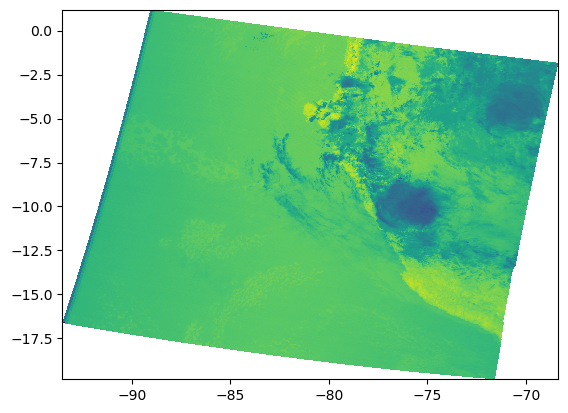

In [27]:
#now we can visualize that ratio 
plt.pcolormesh(lons, lats, scn["30"])

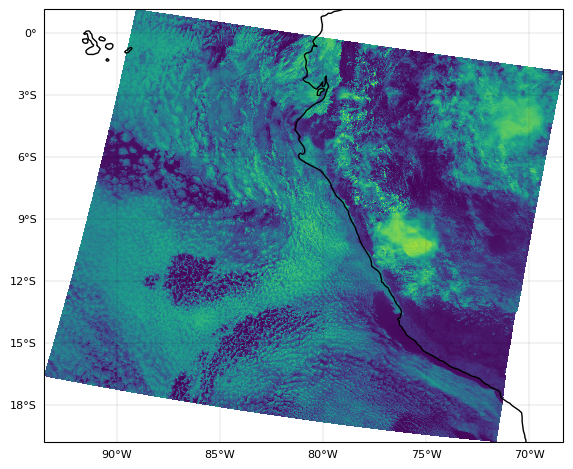

In [28]:
# in an even better way 
fig = plt.figure(dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-20, -10, 30, 60])
ax.pcolormesh(lons, lats, scn["4"], transform=ccrs.PlateCarree())

# ax.set(xlim=[-20, 70,],
#       ylim=[ -10, 70])


# # Add map features with Cartopy 
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                             edgecolor='face', 
#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

## To XArray

In [199]:
from georeader.griddata import read_to_crs

In [200]:
def coords_to_transform(coords) -> rasterio.Affine:
    """
    Compute the bounds and the geotransform from the coordinates of a xr.DataArray object.

    This function is an inverse of the coordinates computation that is in `xr.open_rasterio`

    Args:
        coords: if `data` is an xr.DataArray object data.coords has its coordinates

    Returns:
        Bounds and geotransform of the coordinates.
    """

    resx = float(abs(coords["x"][1] - coords["x"][0]))
    resy = float(abs(coords["y"][1] - coords["y"][0]))
    resx2 = resx / 2.
    resy2 = resy / 2.

    x_min = float(coords["x"][0] - resx2)
    x_max = float(coords["x"][-1] - resx2 + resx)  # why not + resx2
    y_max = float(coords["y"][0] + resy2)
    y_min = float(coords["y"][-1] + resy2 - resy)  # why not - resy2

    # We add in the y coordinate because images are referenced from top coordinate,
    # see xr.open_rasterio or getcoords_from_transform_shape
    bounds = (x_min, y_min, x_max, y_max)

    # Compute affine transform for a given bounding box and resolution.
    transform = rasterio.transform.from_origin(bounds[0], bounds[3], resx, resy)

    return transform

In [201]:
transform = coords_to_transform(out)
transform

Affine(1.0, 0.0, -0.5,
       0.0, -1.0, 0.5)

In [202]:
out = scn.to_xarray_dataset()

In [203]:
out.rio.transform(), coords_to_transform(out)

(Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0),
 Affine(1.0, 0.0, -0.5,
        0.0, -1.0, 0.5))

In [204]:
out = scn.to_xarray_dataset()

# initialize crs
out.rio.write_crs(4326, inplace=True)

# create transformation
transform = coords_to_transform(out)
out.rio.write_transform(transform, inplace=True)

# out.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude")

# get transformation
# transform = coords_to_transform(out)
# out.rio.write_transform(transform, inplace=True)
# out = out.set_coords(["x", "y"])
# out = out.rename({"latitude": "lat", "longitude": "lon"})
# out = out.set_coords(["lat", "lon"])

# out["lon"].attrs = dict(long_name="longitude", units="degrees_east")
# out["lat"].attrs = dict(long_name="latitude", units="degrees_north")

out.rio.write_coordinate_system(inplace=True)
out

<xarray.Dataset> Size: 616MB
Dimensions:      (y: 2030, x: 1354)
Coordinates:
    crs          object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude     (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables: (12/38)
    13hi         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    19           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    34           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    20           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    3            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    10           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...           ...
    14hi         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    4            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    36           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    24           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    35           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    33           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    platform_name:        EOS-Terra
    sensor:               modis
    modifiers:            ()
    file_type:            hdf_eos_data_1000m
    coordinates:          ('longitude', 'latitude')
    start_time:           2018-10-01 09:00:00
    resolution:           1000
    rows_per_scan:        10
    end_time:             2018-10-01 09:05:00
    ancillary_variables:  []
    reader:               modis_l1b
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'array...

In [205]:
out.rio.to_raster("/home/juanjohn/data/rs/modis/analysis/test.tif")

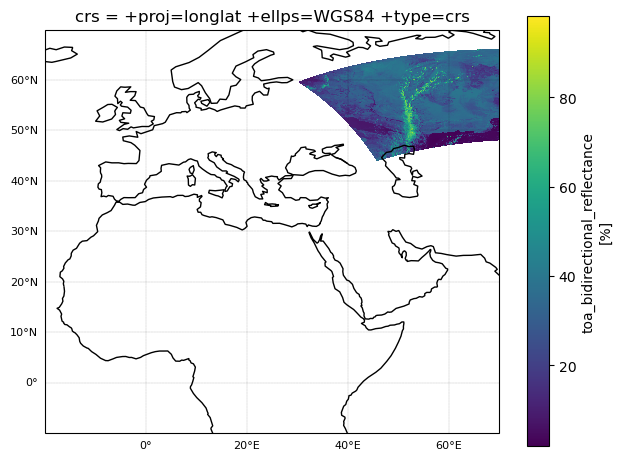

In [10]:
# in an even better way 
fig = plt.figure(dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-20, -10, 30, 60])
# out["1"].plot(ax=ax, transform=ccrs.PlateCarree())
# ax.pcolormesh(out["1"].longitude, out["1"].latitude, out["1"].values)
out["1"].plot.pcolormesh(x="longitude", y="latitude", transform=ccrs.PlateCarree())


ax.set(xlim=[-20, 70,],
      ylim=[ -10, 70])

# # Add map features with Cartopy 
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                             edgecolor='face', 
#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

### Fixing the Coordinate System

In [412]:
ds_crs = out.rio.write_crs("epsg:4326", inplace=True)
# out = out.set_coords(["latitude", "longitude"])
# out = out.rename({"latitude": "lat", "longitude": "lon"})
# out = out.set_coords(["lat", "lon"])

# out["lon"].attrs = dict(long_name="longitude", units="degrees_east")
# out["lat"].attrs = dict(long_name="latitude", units="degrees_north")

# out.rio.write_coordinate_system(inplace=True)
out

<xarray.Dataset> Size: 616MB
Dimensions:      (y: 2030, x: 1354)
Coordinates:
    crs          object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude     (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables: (12/38)
    12           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    27           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    29           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    15           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    24           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    13lo         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...           ...
    4            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    30           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    35           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    13hi         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    21           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    17           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    rows_per_scan:        10
    ancillary_variables:  []
    resolution:           1000
    sensor:               modis
    coordinates:          ('longitude', 'latitude')
    file_type:            hdf_eos_data_1000m
    start_time:           2018-10-01 09:00:00
    modifiers:            ()
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    platform_name:        EOS-Terra
    reader:               modis_l1b
    end_time:             2018-10-01 09:05:00

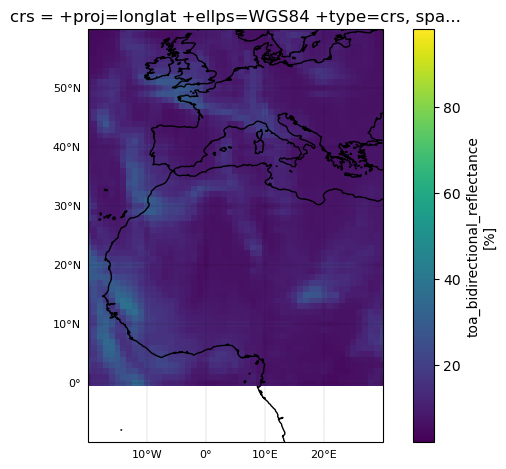

In [416]:
# in an even better way 
fig = plt.figure(dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-20, -10, 30, 60])
# out["1"].plot(ax=ax, transform=ccrs.PlateCarree())
# ax.pcolormesh(out["1"].longitude, out["1"].latitude, out["1"].values)
ds_crs["1"].plot.pcolormesh(x="x", y="y", transform=ccrs.PlateCarree())

ax.set(xlim=[-20, 30,],
      ylim=[ -10, 60])

# # Add map features with Cartopy 
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                             edgecolor='face', 
#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

In [103]:
# scn.available_dataset_names()
# scn.

In [104]:
import cartopy.crs as ccrs
# - Define the CRS of the original data
crs_WGS84 = ccrs.PlateCarree(central_longitude=0) # reference CRS of Swath data


In [105]:
# Define channels 
channels = [str(i) for i in range(1, 39)] 
channels[12] = '13lo'
channels[13] = '14lo'
channels[36] = '13hi'
channels[37] = '14hi'

In [106]:
### Define gridded area into which to reproject 
bbox = (22.21, -72.52, 28.37, -71.57) # PE bounding bbox (LON_MIN,LAT_MIN, LON_MAX, LAT_MAX)

In [109]:
# resample
resolution = 1_000 # km scale
scn.load(channels, resolution = resolution)

In [115]:
scn.start_time

datetime.datetime(2018, 10, 1, 9, 5)

In [127]:
import numpy as np
time_stamp = scn.start_time + (scn.end_time - scn.start_time) / 2
time_stamp.strftime("%Y%m%d%H%M")

'201810010907'

In [129]:
type(time_stamp)

datetime.datetime

In [108]:
out.crs.values

array(<Geographic 2D CRS: +proj=longlat +ellps=WGS84 +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, dtype=object)

In [175]:
out = scn.to_xarray_dataset()
out.rio.write_crs("epsg:4326", inplace=True)
out = out.set_coords(["latitude", "longitude"])
out = out.assign_coords({"latitude": out.latitude, "longitude": out.longitude})
# out.rio.set_spatial_dims(
#     x_dim="lon",
#     y_dim="lat",
#     inplace=True,
# )
out.rio.write_coordinate_system(inplace=True)

# out.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
# out.rio.write_coordinate_system(inplace=True)
out

<xarray.Dataset> Size: 616MB
Dimensions:      (y: 2030, x: 1354)
Coordinates:
    crs          object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude     (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables: (12/38)
    12           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    27           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    29           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    15           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    24           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    13lo         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...           ...
    4            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    30           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    35           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    13hi         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    21           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    17           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    rows_per_scan:        10
    ancillary_variables:  []
    resolution:           1000
    sensor:               modis
    coordinates:          ('longitude', 'latitude')
    file_type:            hdf_eos_data_1000m
    start_time:           2018-10-01 09:05:00
    modifiers:            ()
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    platform_name:        EOS-Terra
    reader:               modis_l1b
    end_time:             2018-10-01 09:10:00

In [48]:
out.rio.to_raster("test.tif")

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


In [190]:
save_dir = "/home/juanjohn/data/rs/modis/analysis"
list_of_files = get_list_filenames(save_dir, "tif")

In [191]:
out_ = xr.open_dataset(list_of_files[0], engine="rasterio")

In [192]:
out_

<xarray.Dataset> Size: 836MB
Dimensions:      (band: 38, x: 1354, y: 2030)
Coordinates:
  * band         (band) int64 304B 1 2 3 4 5 6 7 8 9 ... 31 32 33 34 35 36 37 38
  * x            (x) float64 11kB 0.5 1.5 2.5 ... 1.352e+03 1.352e+03 1.354e+03
  * y            (y) float64 16kB 0.5 1.5 2.5 ... 2.028e+03 2.028e+03 2.03e+03
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float64 836MB ...

In [218]:
out_.rio.bounds

<bound method XRasterBase.bounds of <rioxarray.raster_dataset.RasterDataset object at 0x7fe9ba142250>>

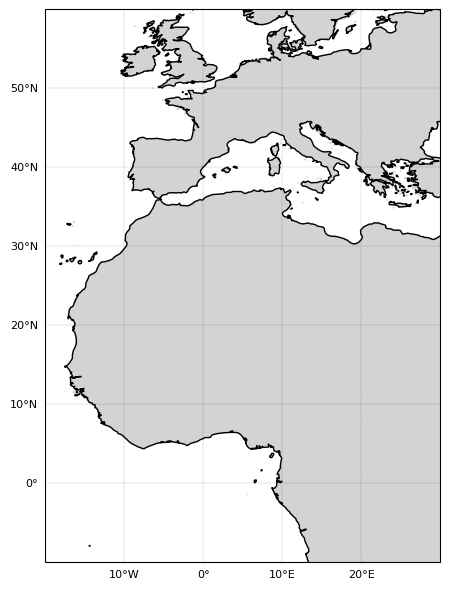

In [286]:
# Defining the figure
fig = plt.figure(figsize=(10,6), facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())

# out_.isel(band=10).band_data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), extent=out_.rio.bounds,)

# Add map features with Cartopy 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                            edgecolor='face', 
                                            facecolor='lightgray'))
ax.coastlines(linewidth=1)

ax.set(xlim=[-20, 30,],
      ylim=[ -10, 60])

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 


plt.tight_layout()
plt.show()

In [224]:
import torchgeo

In [156]:
from torchgeo.datasets import RasterDataset, stack_samples, BoundingBox
from torchgeo.samplers import GridGeoSampler
from torch.utils.data import DataLoader

In [157]:
paths = list_of_files[0]

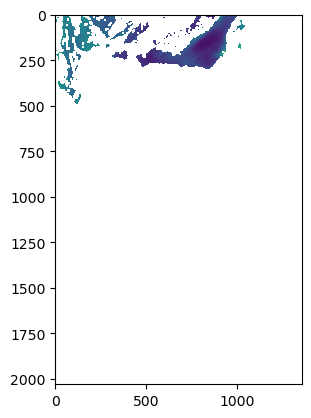

In [179]:
with rasterio.open("/home/juanjohn/data/rs/modis/analysis/test.tif") as f:
    # print(f)
    plt.imshow(f.read(1))

In [167]:
# tds = RasterDataset(paths=list_of_files[0])
tds = RasterDataset(paths="/home/juanjohn/data/rs/modis/analysis/test.tif")
# roi = BoundingBox(40,50,50,60)
sampler = GridGeoSampler(tds, size=(256,256), stride=(256,256), )
tdl = DataLoader(tds, sampler=sampler, collate_fn=stack_samples)

In [168]:
isample[""]

[]

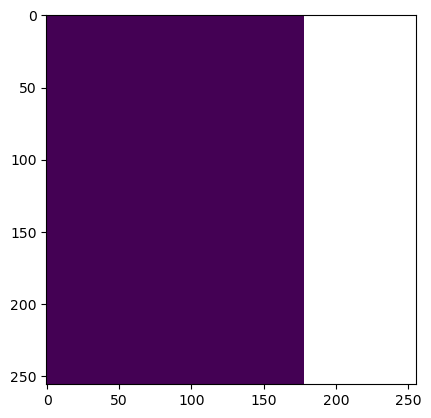

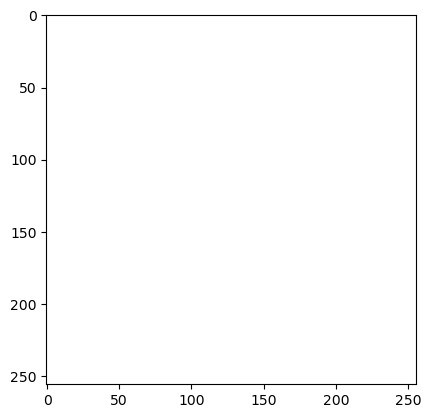

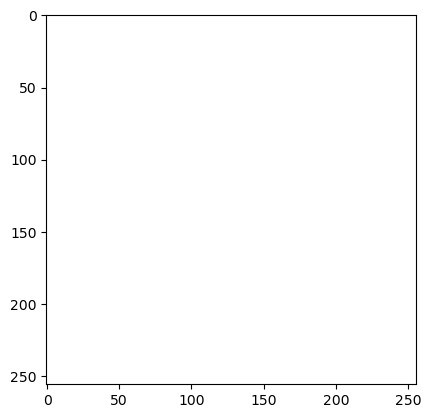

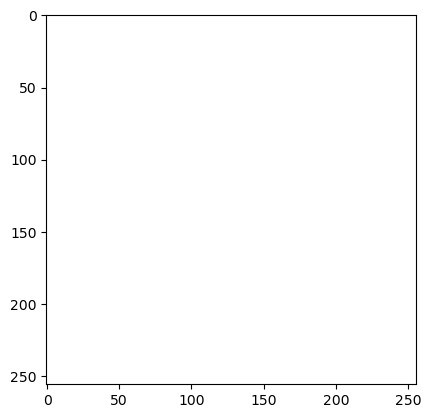

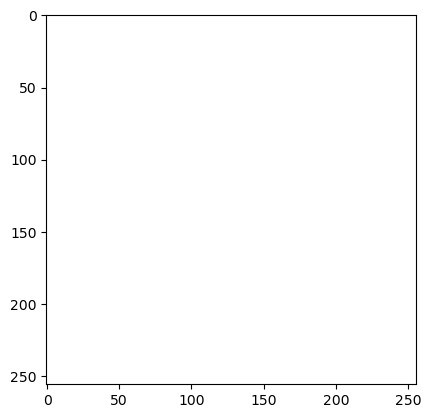

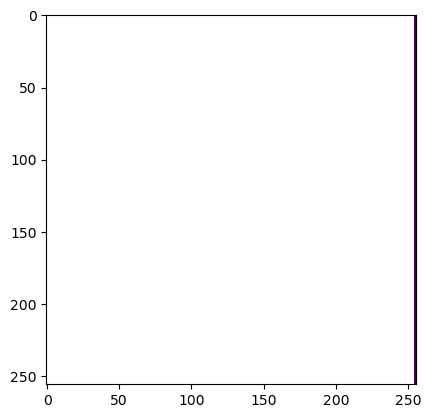

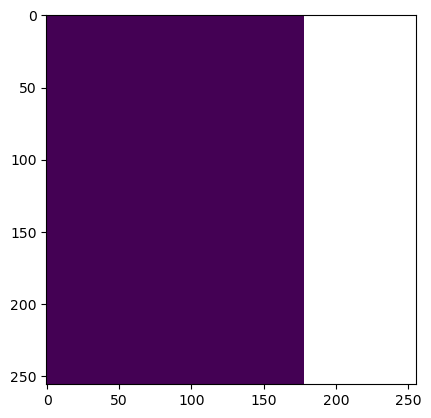

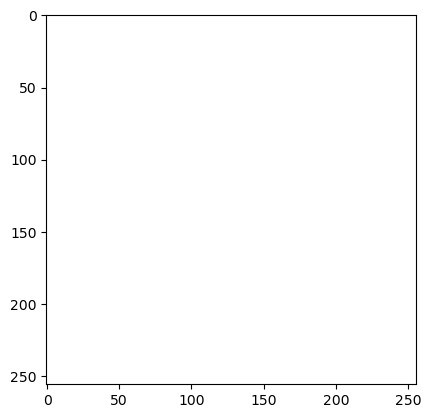

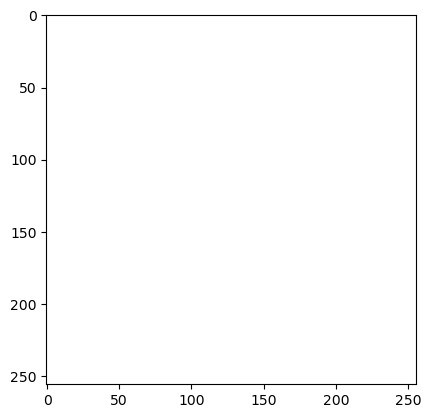

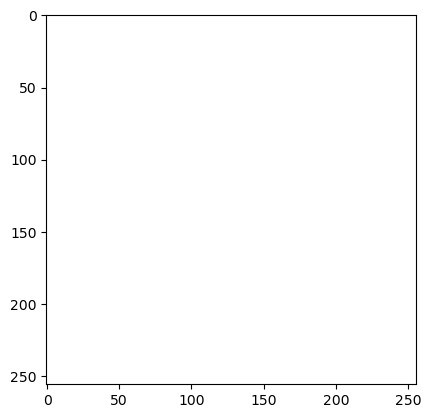

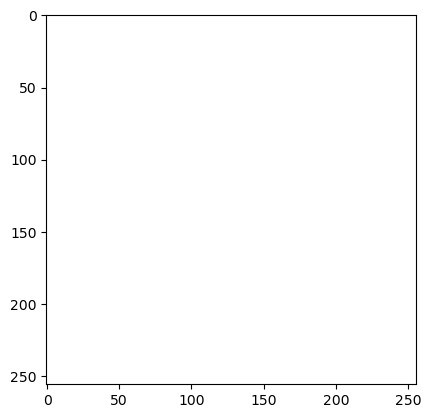

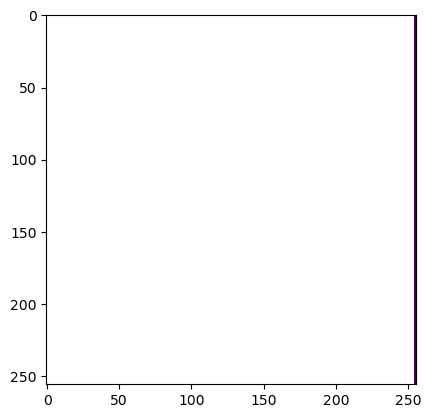

In [169]:
for i, isample in enumerate(tdl):
    fig, ax = plt.subplots()
    
    ax.imshow(isample["image"].numpy().squeeze().transpose(1,2,0)[...,0])
    plt.show()

    if i > 10:
        break


In [150]:
isample["image"].shape

torch.Size([1, 38, 256, 256])

In [143]:
isample["image"].numpy().max() > 0.0

False

In [144]:
isample["image"].max()

tensor(nan)

In [145]:
isample["image"].numpy().squeeze().transpose(1,2,0)[...,1:4]

array([[[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       [[  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ]],

       ...,

       [[ 40.224533, 230.73936 , 264.02652 ],
        [ 38.897587, 231.26094 , 263.35553 ],
        [ 39.64807 , 2

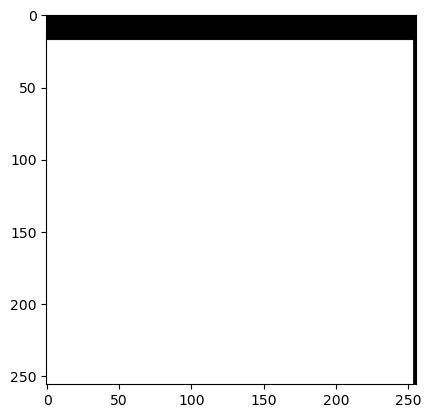

In [126]:
fig, ax = plt.subplots()

ax.imshow(isample["image"].numpy().squeeze().transpose(1,2,0)[...,1:4])
plt.show()

In [64]:
next(iter(tsampler))

BoundingBox(minx=-180.0, maxx=76.0, miny=0.0, maxy=256.0, mint=0.0, maxt=9.223372036854776e+18)

In [56]:
tds[0]

TypeError: 'int' object is not iterable

In [27]:
out.rio.resolution()

DimensionMissingCoordinateError: x missing coordinates.

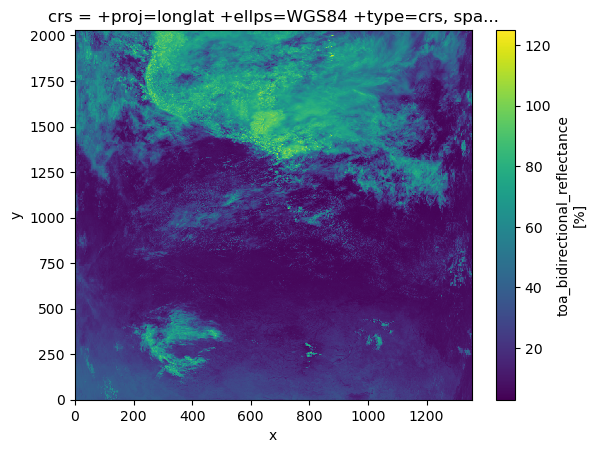

In [26]:
out["1"].plot.pcolormesh()

In [20]:
from rs_tools._src.geoprocessing.grid import create_latlon_grid

In [23]:
LAT_coords, LON_coords = create_latlon_grid(bbox, 0.25)

In [24]:
out.interp(latitude=LAT_coords, longitude=LON_coords)

ValueError: Dimensions {'latitude', 'longitude'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'y': 2030, 'x': 1354})

In [18]:
out.rio.write_crs("epsg:4326", inplace=True)

<xarray.Dataset> Size: 616MB
Dimensions:      (y: 2030, x: 1354)
Coordinates:
    crs          object 8B +proj=longlat +ellps=WGS84 +type=crs
    latitude     (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    longitude    (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Data variables: (12/38)
    12           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    27           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    29           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    15           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    24           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    13lo         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    ...           ...
    4            (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    30           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    35           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    13hi         (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    21           (y, x) float64 22MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
    17           (y, x) float32 11MB dask.array<chunksize=(1540, 1354), meta=np.ndarray>
Attributes:
    rows_per_scan:        10
    ancillary_variables:  []
    resolution:           1000
    sensor:               modis
    coordinates:          ('longitude', 'latitude')
    file_type:            hdf_eos_data_1000m
    start_time:           2018-10-01 09:05:00
    modifiers:            ()
    area:                 Shape: (2030, 1354)\nLons: <xarray.DataArray 'getit...
    platform_name:        EOS-Terra
    reader:               modis_l1b
    end_time:             2018-10-01 09:10:00

In [ ]:
remapped_scn = scn.resample(b)

In [7]:
list_of_files = get_list_filenames(save_dir, "hdf")

In [12]:
ds = xr.open_mfdataset(list_of_files[0], engine="netcdf4")

In [15]:
ds["EV_250_Aggr1km_RefSB"]

<xarray.DataArray 'EV_250_Aggr1km_RefSB' (Band_250M:MODIS_SWATH_Type_L1B: 2,
                                          10*nscans:MODIS_SWATH_Type_L1B: 2030,
                                          Max_EV_frames:MODIS_SWATH_Type_L1B: 1354)> Size: 22MB
dask.array<open_dataset-EV_250_Aggr1km_RefSB, shape=(2, 2030, 1354), dtype=float32, chunksize=(1, 10, 1354), chunktype=numpy.ndarray>
Dimensions without coordinates: Band_250M:MODIS_SWATH_Type_L1B,
                                10*nscans:MODIS_SWATH_Type_L1B,
                                Max_EV_frames:MODIS_SWATH_Type_L1B
Attributes: (12/13)
    long_name:                 Earth View 250M Aggregated 1km Reflective Sola...
    units:                     none
    valid_range:               [    0 32767]
    band_names:                1,2
    radiance_scales:           [0.02959567 0.0109852 ]
    radiance_offsets:          [-0. -0.]
    ...                        ...
    reflectance_scales:        [5.8010475e-05 3.4855915e-05]
    reflectance_offsets:       [-0. -0.]
    reflectance_units:         none
    corrected_counts_scales:   [0.1249733 0.1249733]
    corrected_counts_offsets:  [-0. -0.]
    corrected_counts_units:    counts

ModuleNotFoundError: No module named 'rs_tools'